In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import torch

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080'

# data load (train)

In [4]:
path = 'D:/data/새 폴더/_Noise data'

num_of_files = 1
num_of_datas = 11500


file_list = os.listdir(path)
file_list_py = [file for file in file_list[:num_of_files] if file.endswith('.csv')]
file_list_py

['Si_ 3 times0_1_10000_31426316.csv']

In [5]:
train = pd.DataFrame()
j = 0

for i in file_list_py:
    data = pd.read_csv(path+'/'+i,
                      skiprows=11,
                      nrows = num_of_datas,
                      header = None,
                      names =[j]
                      )
    j = j + 1 
    train = pd.concat([train,data], axis = 1, sort=True)

In [6]:
train

,0
0,-0.016022
1,-0.013428
2,-0.010834
3,-0.008240
4,-0.003815
...,...
11495,0.026093
11496,0.026093
11497,0.028381
11498,0.025177


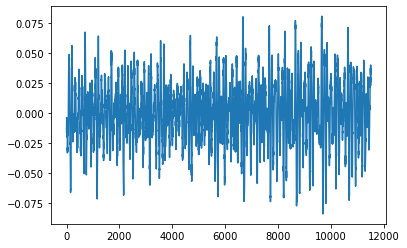

<Figure size 576x72 with 0 Axes>

In [7]:
plt.plot(train)
plt.figure(figsize=(8, 1))
plt.show()

## Data load(valid)

In [8]:
path = 'D:/data/새 폴더/_Noise data'

num_of_files = 20
num_of_datas = 11500


file_list = os.listdir(path)
file_list_py = [file for file in file_list[:num_of_files] if file.endswith('.csv')]
#file_list_py

In [9]:
valid = pd.DataFrame()
j = 0
i = 10


data = pd.read_csv(path+'/'+file_list_py[i],
                   skiprows=11,
                   nrows = num_of_datas,
                   header = None,
                   names =[j]
                   )
j = j + 1 
valid = pd.concat([valid,data], axis = 1, sort=True)

In [10]:
valid

,0
0,-0.039825
1,-0.042725
2,-0.045624
3,-0.048523
4,-0.049133
...,...
11495,0.033417
11496,0.036011
11497,0.038605
11498,0.034027


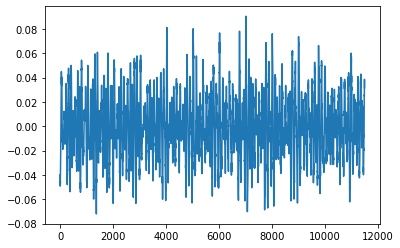

<Figure size 576x72 with 0 Axes>

In [11]:
plt.plot(valid)
plt.figure(figsize=(8, 1))
plt.show()

# Sequence split

In [18]:
Seq_len = 20

In [19]:
def truncate(x, train_len=Seq_len, test_len=1):
    in_, out_ = [], []
    for i in range(len(x) - train_len - test_len +1):
        in_.append(x[i:(i+train_len)].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len)].tolist())
    return np.array(in_), np.array(out_)

In [20]:
train = np.array(train)
valid = np.array(valid)

In [21]:
X_train , y_train = truncate(train)
X_valid , y_valid = truncate(valid)

In [22]:
print(X_train.shape, 
      y_train.shape, 
      X_valid.shape, 
      y_valid.shape)

(11480, 20, 1) (11480, 1, 1) (11480, 20, 1) (11480, 1, 1)


In [23]:
X_train[0]

array([[-0.01602173],
       [-0.01342773],
       [-0.01083374],
       [-0.00823975],
       [-0.0038147 ],
       [-0.00732422],
       [-0.00900269],
       [-0.00610352],
       [-0.00518799],
       [-0.00946045],
       [-0.01235962],
       [-0.01113892],
       [-0.01159668],
       [-0.01434326],
       [-0.01159668],
       [-0.00991821],
       [-0.01464844],
       [-0.01663208],
       [-0.01358032],
       [-0.01190186]])

In [39]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_valid = torch.Tensor(X_valid)
y_valid = torch.Tensor(y_valid)

In [40]:
print(X_train.shape, 
      y_train.shape, 
      X_valid.shape, 
      y_valid.shape)

torch.Size([11480, 20, 1]) torch.Size([11480, 1, 1]) torch.Size([11480, 20, 1]) torch.Size([11480, 1, 1])


# Model

In [29]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
import copy

In [30]:
seq_len = X_train.shape[1]
n_features = X_train.shape[2]

embedding_dim = 64
n_hidden = 100
num_epochs = 200

In [31]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=embedding_dim):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(input_size=n_features,
                            hidden_size=self.hidden_dim,
                            num_layers=1,
                            batch_first=True,
                            dropout = 0.3
                            )
    

    def forward(self, x):

        x, (hidden_n, _) = self.rnn1(x)

        return hidden_n

In [32]:
class Decoder(nn.Module):

      def __init__(self, seq_len, input_dim=embedding_dim, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(input_size= 2*input_dim,
                            hidden_size=input_dim,
                            num_layers=1,
                            batch_first=True,
                            dropout=0.3
                            )


        self.output_layer = nn.Linear(self.input_dim, n_features)
        self.timedist = TimeDistributed(self.output_layer)

      def forward(self, x):

        x, (hidden_n, cell_n) = self.rnn1(x)
#        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.timedist(x)

In [33]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [34]:
class RecurrentAutoencoder(nn.Module):

      def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

      def forward(self, x):
         x = self.encoder(x)
         x = self.decoder(x)

         return x

In [35]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [36]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (rnn1): LSTM(256, 128, batch_first=True, dropout=0.3)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
    (timedist): TimeDistributed(
      (module): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

# Training

In [37]:
def train_model(model, X_train, y_train, X_valid, y_valid, num_epochs):
   
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    criterion = nn.MSELoss().to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    train_losses = []
    val_losses = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       patience = 10, 
                                                       factor =0.5, 
                                                       min_lr=1e-7, 
                                                       eps = 1e-8
                                                      )
    
    
    for epoch in progress_bar(range(num_epochs)):
        model = model.train()
        
        
        optimizer.zero_grad()
        pred = model(X_train.to(device))
        loss = criterion(pred, y_train.to(device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        
    
        model = model.eval()
    
        with torch.no_grad():
            valid = model(X_valid.to(device))
            loss = criterion(valid, y_valid.to(device))
            val_losses.append(loss.item())
    
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)    
    
        history['train'].append(train_loss)
        history['val'].append(val_loss)
    
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
    
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    
    model.load_state_dict(best_model_wts)
    return model.eval(), history        

In [41]:
model, history = train_model(model,
                             X_train, 
                             y_train, 
                             X_valid, 
                             y_valid,
                             num_epochs=num_epochs
                             )

Epoch 0: train loss 0.0021550978999584913 val loss 0.5674972534179688
Epoch 1: train loss 0.28482006618287414 val loss 0.2842168113566004
Epoch 2: train loss 0.1901934877775299 val loss 0.19052998026988158
Epoch 3: train loss 0.14343555840605404 val loss 0.14435755964950658
Epoch 4: train loss 0.11591770349768922 val loss 0.11744442593771964
Epoch 5: train loss 0.09823116162442602 val loss 0.0990434565464966
Epoch 6: train loss 0.08520453535519275 val loss 0.08500565712373438
Epoch 7: train loss 0.07465185502951499 val loss 0.075017931383627
Epoch 8: train loss 0.06692462340773393 val loss 0.06686901190550998
Epoch 9: train loss 0.06040029282448813 val loss 0.06035433792858384
Epoch 10: train loss 0.055066392979245975 val loss 0.05510574891972779
Epoch 11: train loss 0.05069629740319215 val loss 0.05063163433320975
Epoch 12: train loss 0.04690591421408149 val loss 0.04679954676584412
Epoch 13: train loss 0.043613992747850716 val loss 0.04351087345691797
Epoch 14: train loss 0.040757214

Epoch 115: train loss 0.005939908152554537 val loss 0.005923500342760235
Epoch 116: train loss 0.005895469404366982 val loss 0.005879165191286936
Epoch 117: train loss 0.005851783903643205 val loss 0.00583558153584047
Epoch 118: train loss 0.005808832658994787 val loss 0.00579273038125057
Epoch 119: train loss 0.005766597270849161 val loss 0.00575059336842969
Epoch 120: train loss 0.00572505994932726 val loss 0.0057091527798382394
Epoch 121: train loss 0.005684203520745466 val loss 0.005668391517008518
Epoch 122: train loss 0.005644011403986715 val loss 0.00562829304461905
Epoch 123: train loss 0.0056044675617276 val loss 0.0055888413429079995
Epoch 124: train loss 0.005565556447487324 val loss 0.0055500208796001975
Epoch 125: train loss 0.005527262981992126 val loss 0.005511816603035504
Epoch 126: train loss 0.005489572551281111 val loss 0.005474213948913329
Epoch 127: train loss 0.005452471009903093 val loss 0.005437198825802625
Epoch 128: train loss 0.005415944669074415 val loss 0.0

In [42]:
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

In [43]:
# model = torch.load('model.pth')
# model = model.to(device)

# Test result

(0.003, 0.006)

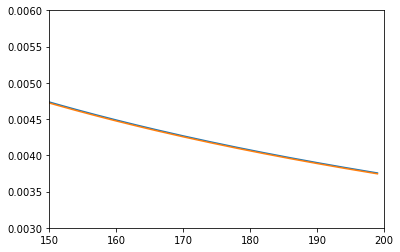

In [81]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.xlim(150,200)
plt.ylim(0.003,0.006)

In [45]:
test = y_valid.squeeze(1)
test.shape

torch.Size([11480, 1])

(0.0, 5000.0)

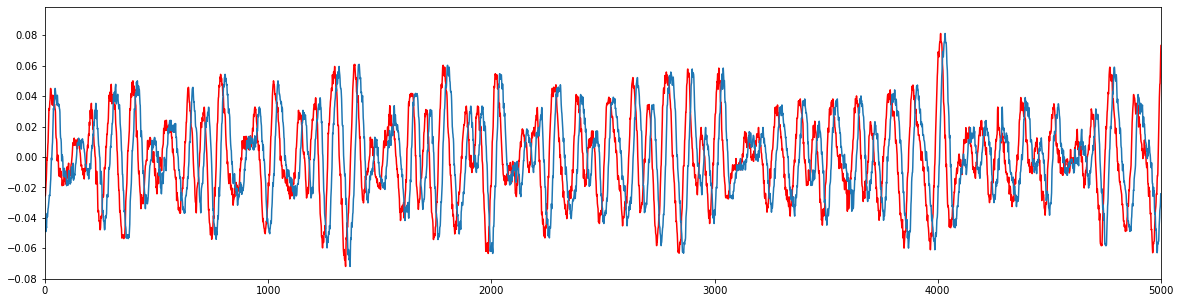

In [67]:
plt.figure(figsize=(20,5))

plt.plot(test,'-r')
plt.plot(valid)

plt.xlim(0,5000)

In [47]:
test.shape #original

torch.Size([11480, 1])

In [48]:
valid.shape #predicted

(11500, 1)

# denoised

(0.0, 1000.0)

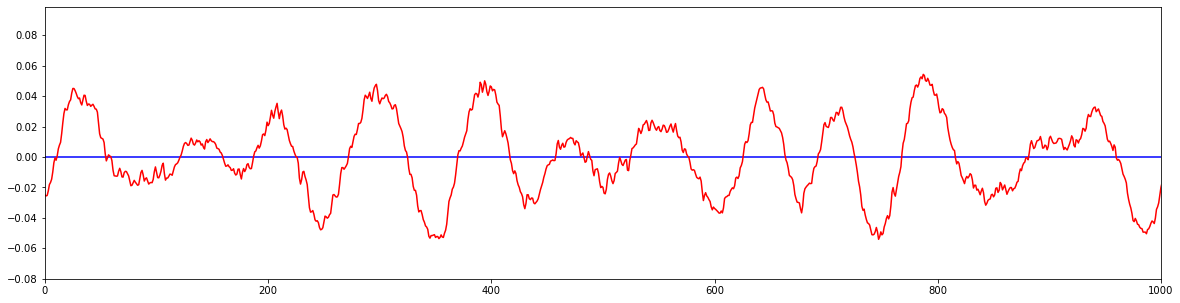

In [49]:
plt.figure(figsize=(20,5))
plt.plot(test-valid[seq_len:11500],'-b') #denoised
plt.plot(test,'-r') #original

plt.xlim(0,1000)

(0.0, 1000.0)

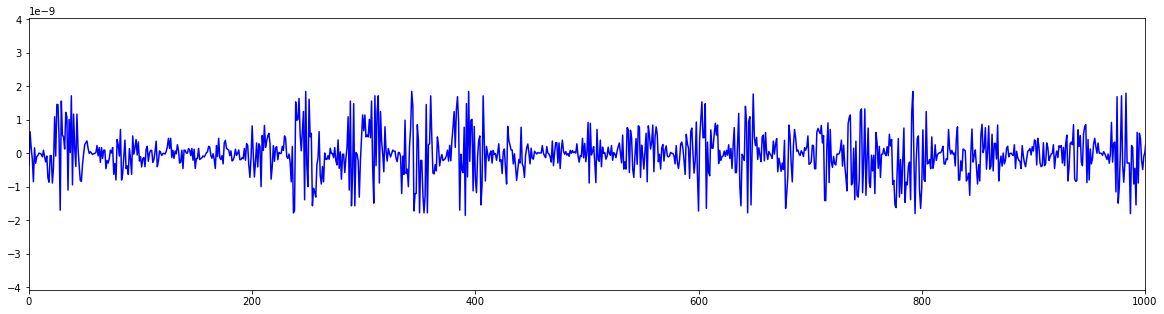

In [50]:
plt.figure(figsize=(20,5))
plt.plot(test-valid[seq_len:11500],'-b') #denoised
plt.xlim(0,1000)

# Predict the noise with small data length

In [85]:
path = 'D:/data/새 폴더/_Noise data'
filename = 'Si_ 3 times0_1_54414_174097422.csv'

num_of_datas = 11500

In [86]:
    TData = pd.DataFrame()
    j = 0


    data = pd.read_csv(path+'/'+filename,
                      skiprows=11,
                      nrows = num_of_datas,
                      header = None,
                      names =[j]
                      )
    j = j + 1 
    TData = pd.concat([TData,data], axis = 1, sort=True)

In [87]:
TData

,0
0,-0.027008
1,-0.023193
2,-0.019379
3,-0.015564
4,-0.013428
...,...
11495,0.021362
11496,0.019531
11497,0.016479
11498,0.015564


In [88]:
TData = np.array(TData)

In [89]:
X_test2, y_test2 = truncate(TData)
X_test2 = torch.Tensor(X_test2)
y_test2 = torch.Tensor(y_test2)

In [90]:
X_test2.shape

torch.Size([11480, 20, 1])

In [91]:
test_prediction = model(X_test2.to(device))

In [92]:
test_prediction

tensor([[[-2.1451e-02],
         [-2.6408e-03],
         [-1.7375e-03],
         ...,
         [ 8.9414e-05],
         [ 9.7603e-05],
         [ 1.1402e-04]]], device='cuda:0', grad_fn=<ViewBackward>)

In [93]:
R = test_prediction.squeeze()

In [94]:
R = R.cpu()
R = R.detach().numpy()


(0.0, 100.0)

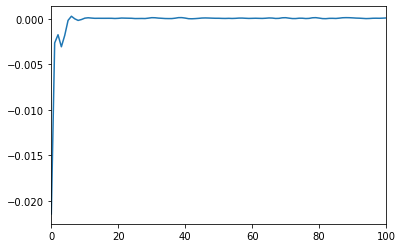

In [95]:
plt.plot(R)
#plt.plot(y_test2.squeeze())
plt.xlim(0, 100)
